In [1]:
import warnings
warnings.filterwarnings('ignore')


import pandas as pd
import numpy as np
from plotnine import *

# modelling
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelBinarizer #Z-score variables

# performance
from sklearn.metrics import accuracy_score, confusion_matrix,\
 f1_score, recall_score, precision_score, roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.calibration import calibration_curve

# model validation imports
from sklearn.model_selection import train_test_split # simple TT split cv
from sklearn.model_selection import KFold # k-fold cv
from sklearn.model_selection import LeaveOneOut #LOO cv

# pipeline imports
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import make_column_transformer

# Review

## Metrics
Once we build a classification model, it's important to make sure that we know how it performs! We talked about a few metrics you can calculate to help you assess how well your model is doing. 

- Accuracy: $\frac{TP + TN}{TP + TN + FP + FN}$
- Confusion Matrix Patterns

|                 | **Actually 1**          | **Actually 0**          |
|-----------------|-------------------------|-------------------------|
| **Predicted 1** | True Positive **(TP)**  | False Positive **(FP)** |
| **Predicted 0** | False Negative **(FN)** | True Negative **(TN)**  |

But there are [others](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics)!

- **Precision**: $\frac{TP}{TP + FP}$, how many of the predicted positives are true positives?

- **Recall/Sensitivity**: $\frac{TP}{TP + FN}$, how many of the actual positives did we accurately predict? 

- **Specificity**: $\frac{TN}{TN + FP}$, how many of the actual negatives did we accurately predict?

- **F1 Score**: $\frac{2 * Precision * Recall}{Precision + Recall}$, a combination of precision and recall.

- **ROC AUC**: The area under the ROC curve which puts the False Positive Rate (FPR) on the x-axis, and the True Positive Rate on the y-axis.

### Question

If you were designing a Flu test, which of these metrics would be most important to you (there's no one right answer) and why?

<img src="https://drive.google.com/uc?export=view&id=1ghyQPx1N8dmU3MV4TrANvqNhGwnLni72" alt="Q" width = "200"/>

## ROC AUC

<img src="https://drive.google.com/uc?export=view&id=1n-Pg6y8wD-UM05kPyVKorbmteMpHdmcG" alt="ROCAUC Curve" width = "600"/>

### Question
What do you think this model's ROC AUC is? Is it closer to 0.5 or 1?

<img src="https://drive.google.com/uc?export=view&id=1ghyQPx1N8dmU3MV4TrANvqNhGwnLni72" alt="Q"  width = "200"/>

## Calibration
We also talked about model **calibration** which measures how closely a model's predicted probabilities match that actual probabilities of the data point being positive.

Calibration isn't necessary for an *accurate* prediction, but if we want to use the model's predicted probabilities, we need to make sure they're well-calibrated. 

<img src="https://drive.google.com/uc?export=view&id=1MRzfxWOaLumqtVHVGGm0kY5gPah-3mxC" alt="Q" width = "600"/>



# `sklearn`

## Lizzo
Let's build a Logistic Regression Model to predict the `mode` of different Lizzo songs. Then we'll check the performance of the model, as well as the calibration.

In [2]:
d = pd.read_csv("https://raw.githubusercontent.com/cmparlettpelleriti/CPSC392ParlettPelleriti/master/Data/Lizzo_data.csv")

# turn boolean into 0's and 1's (not necessary, but helps with confusion over True/False)
d["explicit"] = d["explicit"].astype("int")
d.head()

,Unnamed: 0,artist_name,artist_id,album_id,album_type,album_release_date,album_release_year,album_release_date_precision,danceability,energy,...,track_name,track_preview_url,track_number,type,track_uri,external_urls.spotify,album_name,key_name,mode_name,key_mode
0,1,Lizzo,56oDRnqbIiwx4mymNEv7dS,6dFFcYQ8VhifgdKgYY5LYL,album,2019-04-19,2019,day,0.566,0.660,...,Cuz I Love You,https://p.scdn.co/mp3-preview/04472d81bc5a9669...,1,track,spotify:track:6YdQgWSpsxhVeX6Xmv3IFJ,https://open.spotify.com/track/6YdQgWSpsxhVeX6...,Cuz I Love You,C#,major,C# major
1,2,Lizzo,56oDRnqbIiwx4mymNEv7dS,6dFFcYQ8VhifgdKgYY5LYL,album,2019-04-19,2019,day,0.694,0.807,...,Like a Girl,https://p.scdn.co/mp3-preview/4f917112d7f75e2c...,2,track,spotify:track:5I7sGubUsKo4mVJpBoSVUr,https://open.spotify.com/track/5I7sGubUsKo4mVJ...,Cuz I Love You,D,major,D major
2,3,Lizzo,56oDRnqbIiwx4mymNEv7dS,6dFFcYQ8VhifgdKgYY5LYL,album,2019-04-19,2019,day,0.767,0.889,...,Juice,https://p.scdn.co/mp3-preview/7ca1598cec36c491...,3,track,spotify:track:0k664IuFwVP557Gnx7RhIl,https://open.spotify.com/track/0k664IuFwVP557G...,Cuz I Love You,G,major,G major
3,4,Lizzo,56oDRnqbIiwx4mymNEv7dS,6dFFcYQ8VhifgdKgYY5LYL,album,2019-04-19,2019,day,0.693,0.849,...,Soulmate,https://p.scdn.co/mp3-preview/467bc6a734bfb66e...,4,track,spotify:track:6h2wpo2pshM8QnAvRySEO0,https://open.spotify.com/track/6h2wpo2pshM8QnA...,Cuz I Love You,G,major,G major
4,5,Lizzo,56oDRnqbIiwx4mymNEv7dS,6dFFcYQ8VhifgdKgYY5LYL,album,2019-04-19,2019,day,0.674,0.542,...,Jerome,https://p.scdn.co/mp3-preview/8f662de51ad3f613...,5,track,spotify:track:3kxsEF30mM0TZWfkOv4XsS,https://open.spotify.com/track/3kxsEF30mM0TZWf...,Cuz I Love You,G#,major,G# major


In [4]:
predictors = ["danceability", "energy", "instrumentalness", "explicit"]
contin = ["danceability", "energy", "instrumentalness"]

X = d[predictors]
y = d["mode"]

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state = 123)
#random_state makes sure we have the same split each time

# Create Empty Model
pre = make_column_transformer((StandardScaler(), contin),
                              remainder = "passthrough")
lr = LogisticRegression()

pipe = Pipeline([("pre", pre), ("model", lr)])

# fit
pipe.fit(X_train, y_train)

# predict

y_pred_train = pipe.predict(X_train)
y_pred_test = pipe.predict(X_test)

y_pred_train_prob = pipe.predict_proba(X_train)[:,1]
y_pred_test_prob = pipe.predict_proba(X_test)[:,1]

# assess
print("Train Acc       : ", accuracy_score(y_train, y_pred_train))
print("Train Prescision: ", precision_score(y_train, y_pred_train))
print("Train Recall    : ", recall_score(y_train, y_pred_train))
print("Train F1        : ", f1_score(y_train, y_pred_train))
print("Train ROC AUC   : ", roc_auc_score(y_train, y_pred_train_prob))


print("Test Acc        : ", accuracy_score(y_test, y_pred_test))
print("Test Prescision : ", precision_score(y_test, y_pred_test))
print("Test Recall     : ", recall_score(y_test, y_pred_test))
print("Test F1         : ", f1_score(y_test, y_pred_test))
print("Test ROC AUC    : ", roc_auc_score(y_test, y_pred_test_prob))


Train Acc       :  0.6842105263157895
Train Prescision:  0.6756756756756757
Train Recall    :  1.0
Train F1        :  0.8064516129032258
Train ROC AUC   :  0.676923076923077
Test Acc        :  0.7
Test Prescision :  0.7
Test Recall     :  1.0
Test F1         :  0.8235294117647058
Test ROC AUC    :  0.5238095238095238


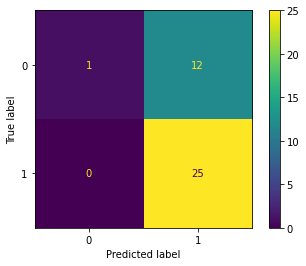

In [5]:
# confusion
ConfusionMatrixDisplay.from_predictions(y_train,y_pred_train)

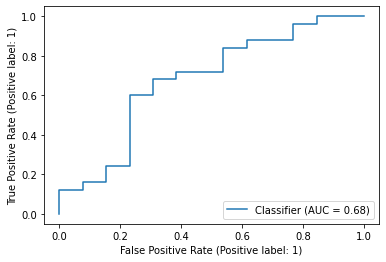

In [6]:
# rocauc
RocCurveDisplay.from_predictions(y_train, y_pred_train_prob)

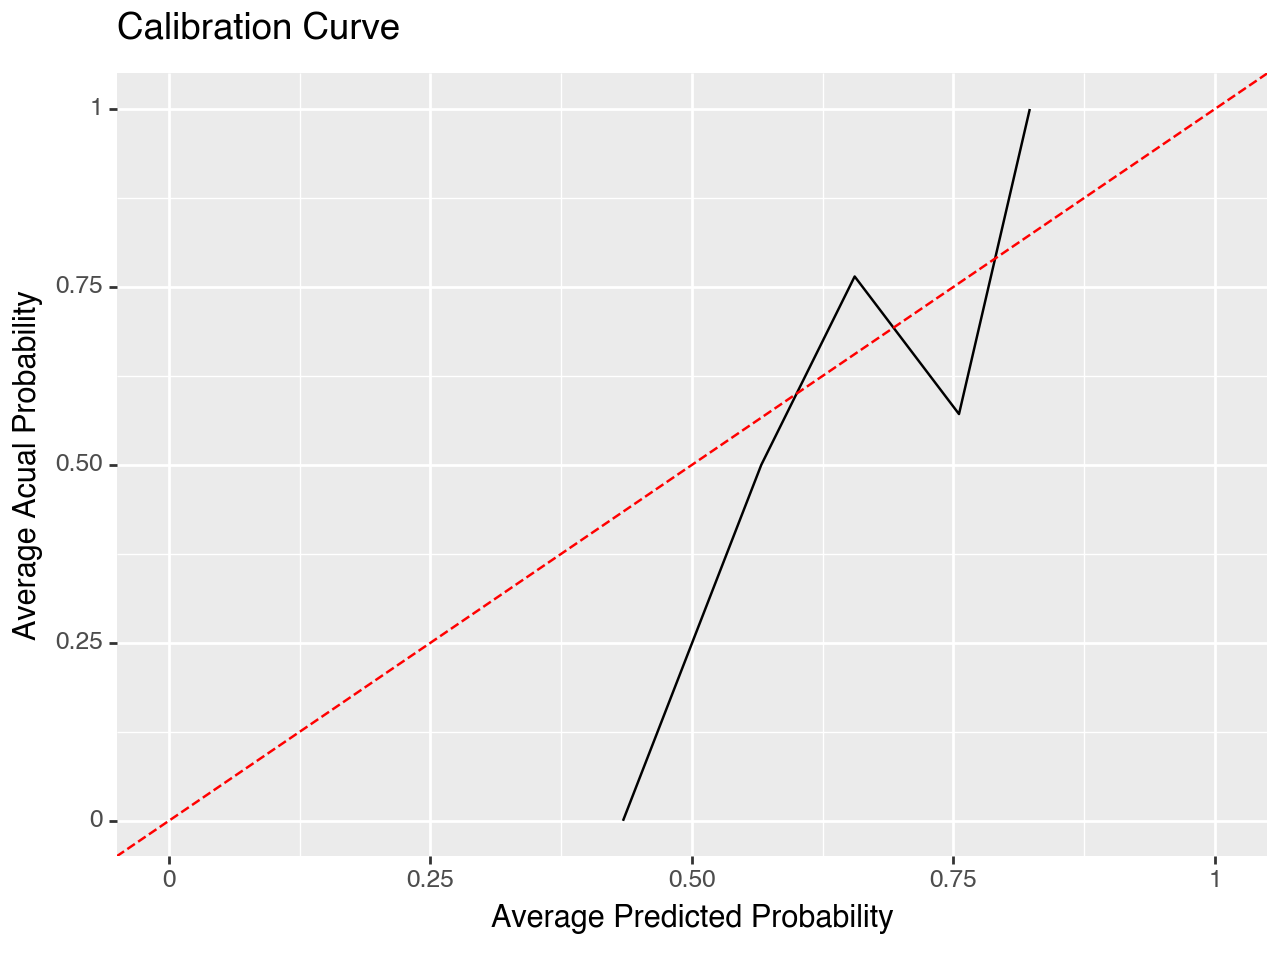

<Figure Size: (640 x 480)>

In [7]:
# calibration
prob_true, prob_pred = calibration_curve(y_train, y_pred_train_prob, n_bins=10)

(ggplot() + geom_line(aes(x = prob_pred, y = prob_true))
+ geom_abline(slope = 1, intercept = 0, color = "red", linetype = "dashed") + 
labs(x = "Average Predicted Probability",
     y = "Average Acual Probability", 
     title = "Calibration Curve") + 
ylim([0,1]) + xlim([0,1]))

In [8]:
# coefs
coefficients = pd.DataFrame({"Coef": pipe.named_steps['model'].coef_[0], # grab array of coefficients
                            "Name": predictors})
intercept = pd.DataFrame({"Coef": pipe.named_steps['model'].intercept_[0], # grab intercept
                                   "Name": "intercept"},
                                   index = [coefficients.shape[0]]) # since this is only 1 row, assign row a row index

coefficents_all = pd.concat([coefficients,intercept])
coefficents_all["Odds"] = np.exp(coefficents_all["Coef"])
coefficents_all

,Coef,Name,Odds
0,-0.311998,danceability,0.731983
1,0.291403,energy,1.338304
2,-0.079619,instrumentalness,0.923468
3,-0.529251,explicit,0.589046
4,1.030444,intercept,2.802308


## Coefficients

Interpret the coefficients above. 

## Another Example

Now let's do the same thing but with [this dataset](https://www.kaggle.com/datasets/ruthgn/wine-quality-data-set-red-white-wine). Download the data from Kaggle, and upload it to Colab.

Let's build a model that predicts whether a wine is `red` or `white` using *all* the other variables.

(NOTE: because the column `type` is a string not a binary `0`/`1` variable, we'll need to use [`LabelBinarizer()`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelBinarizer.html) to turn it into a binary variable.)

In [54]:
# load in data
w = pd.read_csv("wine-quality-white-and-red.csv")
# w.head()

# check missing


# drop


# Binarize and X and Y



# TTS

# Create Empty Model


# fit


# predict


# assess


In [55]:
# calibration


# In Your Groups

## The Math of Log Odds, Odds, and Probabilities

In the lecture, you saw a beautiful (if I do say so myself...) graph demonstrating the way that Log Odds, Odds, and Probabilities change as a result of a 1-unit change in a predictor variable.

Now YOU'RE going to make your own version to help you gain an intuitive sense for the math of log odds, odds, and probabilities. 

We're going to write a function that simulates a super simple logistic relationship: 1 predictor (X) and 1 binary outcome (y). 

(if it helps, think of this as predicting whether or not someone is registered to vote based on their age. **OH SPEAKING OF**: are you [registered to vote](https://www.usa.gov/register-to-vote)?)

In [52]:
def LogisticDataSimulator(intercept, slope, limits = 5):
    
    #generate 1000 evenly spaced values between -limits and limits
    predictor = np.linspace(-limits, limits, 1000)
    
    # log odds of being registered to vote
    log_odds = intercept + slope*predictor
    
    
    # odds of being registered to vote
    odds = np.exp(log_odds)
    
    
    # probability of being registered to vote
    probabilities =  odds/(1 + odds)
    

    
    # put into a dataframe
    df = pd.DataFrame({"x": predictor,
                      "logodds": log_odds,
                       "odds": odds,
                       "probabilities": probabilities})
    
    return(df)

Use the dataframe that calling `LogisticDataSimulator()` with an intercept of 1 and slope of 0.5 makes, and recreate the graph of the log odds, odds, and probabilities from the [lecture](https://github.com/cmparlettpelleriti/CPSC392ParlettPelleriti/blob/master/Lectures/LectureSlides/10_LogisticRegressionII.pdf). Make separate graphs for logodds, odds, and probabilities to make your life easier.

I don't believe that plotnine supports subtitles, so no need to include those but include the colored lines, the titles/axis labels, and the dotted vertical lines! Don't be afraid to google how to do things in ggplot (hint: google `geom_line()` and `geom_vline()`).

In [53]:
plot_data = LogisticDataSimulator(intercept = 1, slope = 0.5)

#################################
# YOUR CODE HERE 
#################################

### *Question*

Describe in detail how the graphs demonstrate what we learned in class: that the change in predicted probability in response to a 1 unit increase of our predictor is *not constant*? Why might this cause an issue?

<img src="https://drive.google.com/uc?export=view&id=1ghyQPx1N8dmU3MV4TrANvqNhGwnLni72" width = 200px />
